# Hamiltonian-based mixflows

Here we develop the code for dealing with continuous data
via mixflows using deterministic Hamiltonian dynamics.

In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams["figure.figsize"]=15,7.5
plt.rcParams.update({'font.size': 24})

In [2]:
def lqN(x,rho,u,N,L,eps,lq0,gradlp,momentum='laplace',xi=np.pi/16):
    xc,rhoc,uc=np.copy(x),np.copy(rho),np.copy(u)
    if N==1: return lq0(xc,rhoc,uc)
    w=np.zeros((N,xc.shape[1]))
    w[0,:]=lq0(xc,rhoc,uc)
    LJ=np.zeros(x.shape[1])
    for n in range(N-1):
        xc,rhoc,uc,tlj=flow(xc,rhoc,uc,1,L,eps,gradlp,momentum,xi,direction='bwd')
        print('logJacobian: '+str(tlj[0]))
        LJ=LJ+tlj
        print('cum lJ: '+str(LJ[0]))
        print('curr lq0: '+str(lq0(xc,rhoc,uc)))
        w[n+1,:]=lq0(xc,rhoc,uc)-LJ
        print()
    # end for
    print(w)
    return LogSumExp(w)-np.log(N)
    

def flow(x,rho,u,steps,L,eps,gradlp,momentum='laplace',xi=np.pi/16,direction='fwd'):
    xc,rhoc,uc=np.copy(x),np.copy(rho),np.copy(u)
    if steps==0: return xc,rhoc,uc,np.zeros(xc.shape[1])
    
    # define laplace functions
    if momentum=='laplace':
        lm = lambda rho : laplace_lm(rho)
        gradlm = lambda rho : laplace_gradlm(rho)
        Fm = lambda rho : laplace_Fm(rho)
        Qm = lambda p : laplace_Qm(p)
        
    ljs=np.zeros(xc.shape[1])
    for t in range(steps):
        if direction=='fwd': xc,rhoc,uc,tljs=T_Leps_fwd(xc,rhoc,uc,L,eps,gradlp,lm,gradlm,Fm,Qm,xi)
        if direction=='bwd': xc,rhoc,uc,tljs=T_Leps_bwd(xc,rhoc,uc,L,eps,gradlp,lm,gradlm,Fm,Qm,xi)
        ljs+=tljs
    # end for
    return xc,rhoc,uc,ljs
    

def T_Leps_fwd(x,rho,u,L,eps,gradlp,lm,gradlm,Fm,Qm,xi=np.pi/16):
    #print('Starting forwards step')
    #print('Initial x: '+str(x[...,0]))
    #print('Initial rho: '+str(rho[...,0]))
    x,rho=Hamiltonian_update(x,rho,L,eps,gradlp,gradlm)
    u=(u+xi)%1
    lJ=lm(rho)
    rho=Qm((Fm(rho)+prz(x,u))%1)
    lJ=lJ-lm(rho)
    #print('Final x: '+str(x[...,0]))
    #print('Final rho: '+str(rho[...,0]))
    #print()
    return x,rho,u,lJ

def T_Leps_bwd(x,rho,u,L,eps,gradlp,lm,gradlm,Fm,Qm,xi=np.pi/16):
    #print('Starting backwards step')
    #print('Initial x: '+str(x[...,0]))
    #print('Initial rho: '+str(rho[...,0]))
    lJ=lm(rho)
    rho=Qm((Fm(rho)-prz(x,u))%1)
    lJ=lJ-lm(rho)
    u=(u-xi)%1
    x,rho=Hamiltonian_update(x,rho,L,-eps,gradlp,gradlm)
    #print('Final x: '+str(x[...,0]))
    #print('Final rho: '+str(rho[...,0]))
    #print()
    return x,rho,u,lJ

def Hamiltonian_update(x,rho,L,eps,gradlp,gradlm):
    #print('Starting Hamiltonian update')
    #print('Initial x: '+str(x))
    for l in range(L):
        rho+=eps*gradlp(x)/2
        x  -=eps*gradlm(rho)
        rho+=eps*gradlp(x)/2
    # end for
    #print('Final x: '+str(x))
    #print()
    return x,rho
    
    
def prz(x,u): return 0.5*np.sin(2*x+u[np.newaxis,:])+0.5
def laplace_lm(rho): return -np.sum(np.abs(rho),axis=0)-np.log(2)
def laplace_gradlm(rho): return -np.sign(rho)
def laplace_Fm(rho): return -0.5*np.sign(rho)*np.exp(-np.sign(rho)*rho)+0.5+0.5*np.sign(rho)
def laplace_Qm(p): return -np.sign(p-0.5)*np.log1p(-2*np.abs(p-0.5))


def LogSumExp(w):
    # LogSumExp trick
    #
    # inputs:
    #    w : (N,d) array, exponents
    #
    # outputs:
    #    w' : (N,d) array, log(sum(exp(w)))
    wmax = np.amax(w,axis=0)
    return wmax + np.log(np.sum(np.exp(w-wmax[np.newaxis,:]),axis=0))

In [20]:
# define the target density and score
def lp(x): return -0.5*np.sum(x**2,axis=0)-0.5*x.shape[0]*np.log(2*np.pi)
def gradlp(x): return -x

# reference distribution
sd0=0.5
mu0=5
gauss_lp = lambda x : -0.5*np.sum((x-mu0)**2,axis=0)/sd0**2-0.5*x.shape[0]*np.log(2*np.pi*sd0**2)
def lq0(x,rho,u): return gauss_lp(x)+laplace_lm(rho)
def randq0(size,M=1): return mu0+sd0*np.random.randn(M,size), np.random.laplace(size=(M,size)),np.random.rand(size)

M=1
d=1000
xi=np.pi/17
x,rho,u=randq0(d,M)

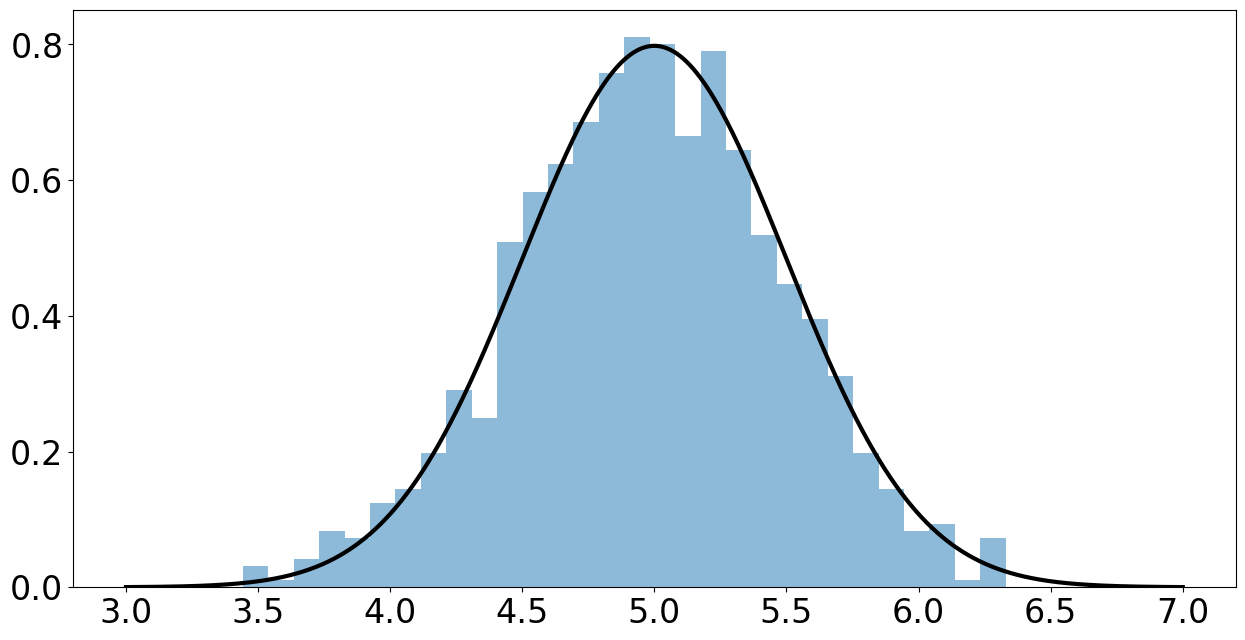

In [71]:
ls=np.linspace(5-4*sd0,5+4*sd0,1000)
for m in range(M): plt.hist(x[m,:],bins=30,density=True, alpha=0.5);
plt.plot(ls,np.exp(gauss_lp(ls[np.newaxis,:])),lw=3,c='black',label=r'$q_0(x)$')
#plt.plot(np.sort(x[0,:]),np.exp(gauss_lp(np.sort(x))),lw=3,c='black',label=r'$q_0(x)$')

In [5]:
steps=100
L=50
eps=0.01
tx,trho,tu,tljs=flow(x,rho,u,steps,L,eps,gradlp,momentum='laplace',direction='fwd',xi=xi)

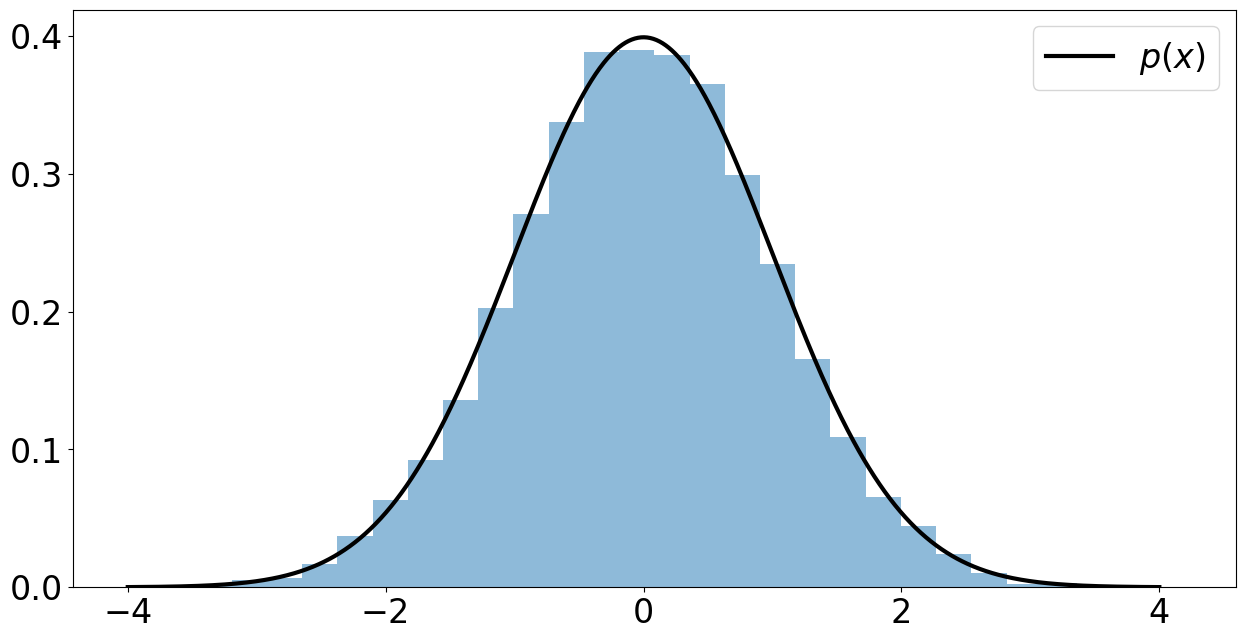

In [6]:
ls=np.linspace(-4,4,1000)
for m in range(M): plt.hist(tx[m,:],bins=30,alpha=0.5,density=True)
plt.plot(ls,np.exp(lp(ls[np.newaxis,:])),lw=3,c='black',label=r'$p(x)$')
plt.legend()

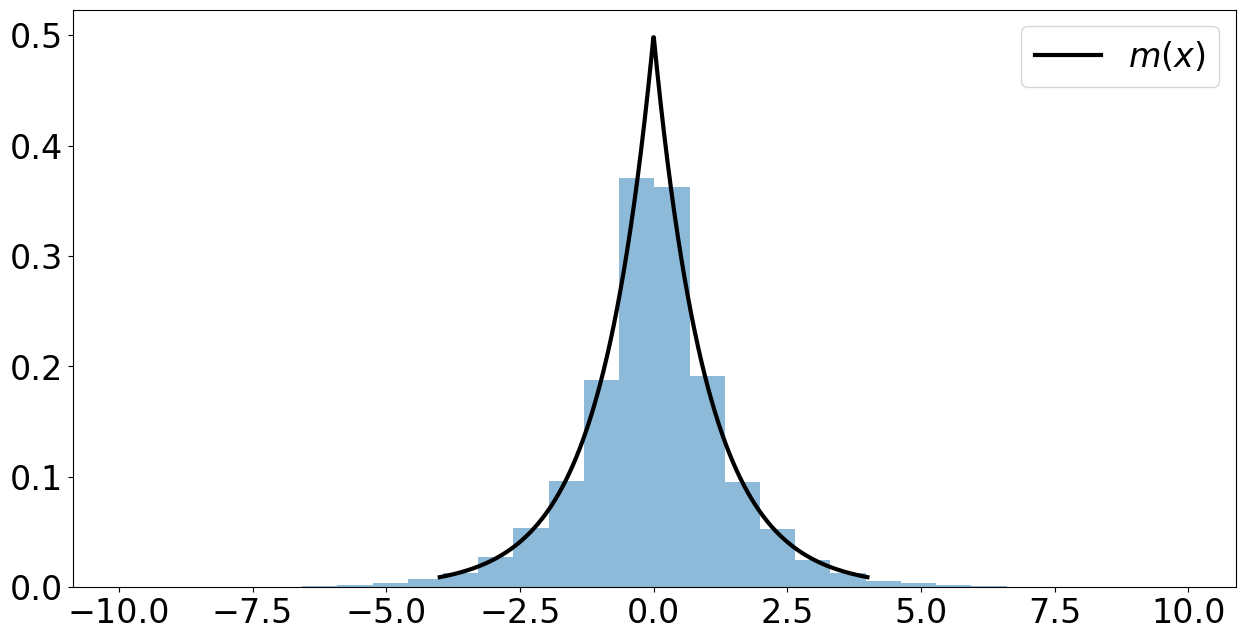

In [7]:
ls=np.linspace(-4,4,1000)
for m in range(M): plt.hist(trho[m,:],bins=30,alpha=0.5,density=True)
plt.plot(ls,np.exp(laplace_lm(ls[np.newaxis,:])),lw=3,c='black',label=r'$m(x)$')
plt.legend()

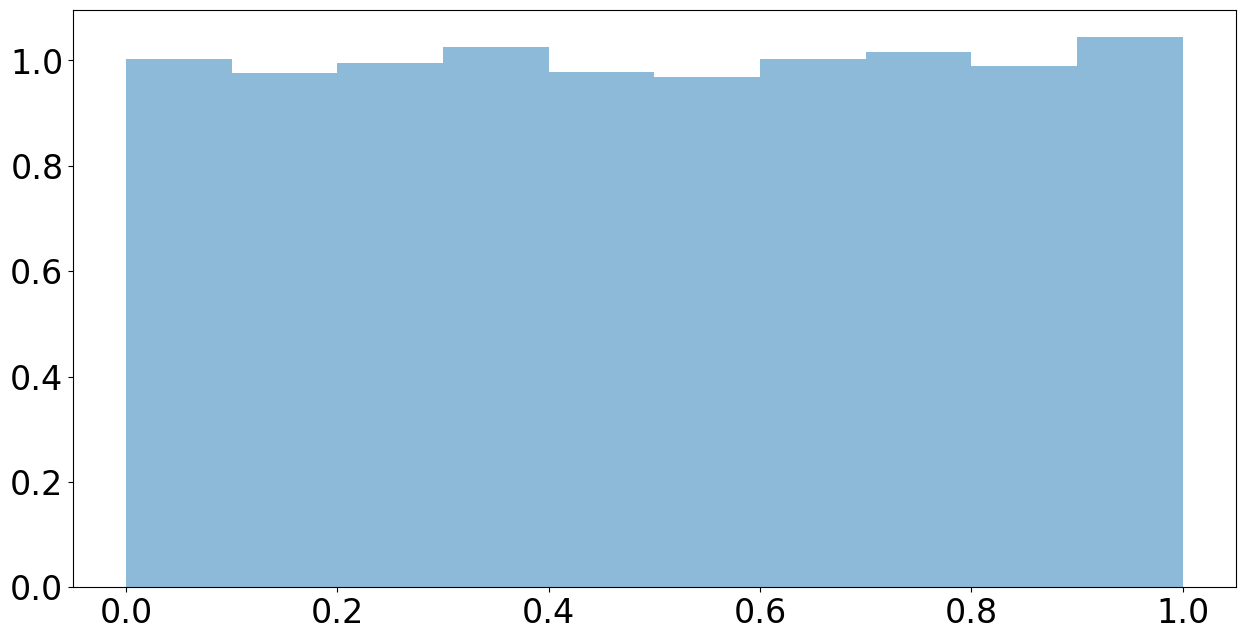

In [8]:
ls=np.linspace(-4,4,1000)
plt.hist(tu,bins=10,alpha=0.5,density=True);

In [9]:
ttx,ttrho,ttu,tljs=flow(tx,trho,tu,steps,L,eps,gradlp,momentum='laplace',direction='bwd',xi=xi)

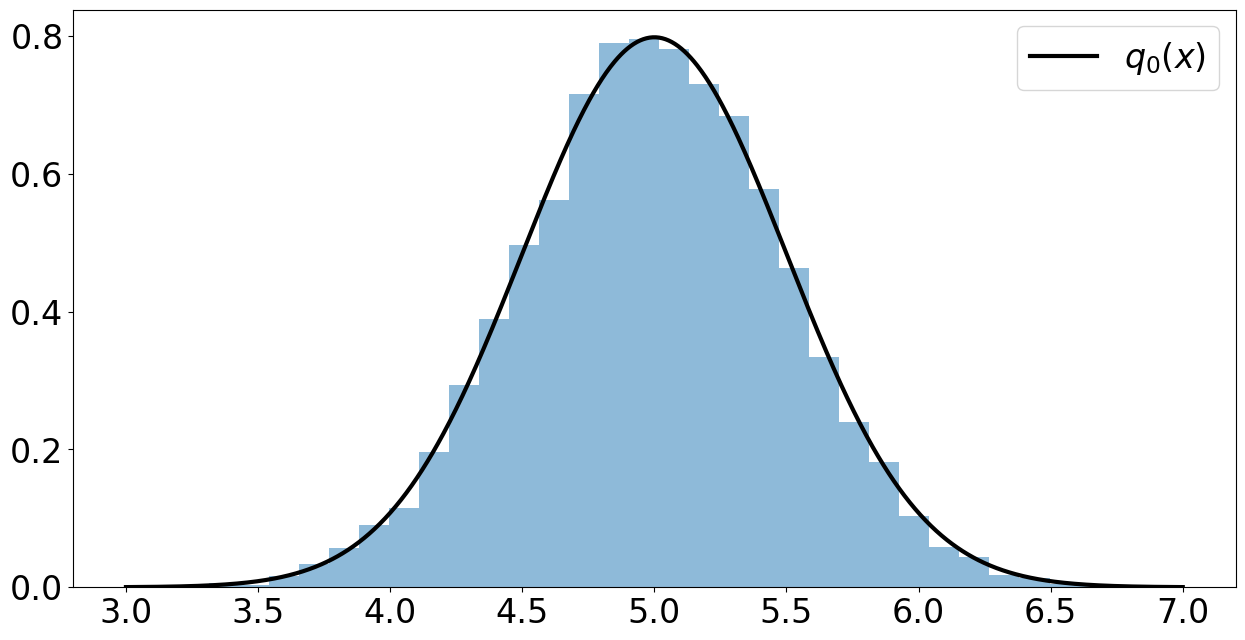

In [10]:
ls=np.linspace(mu0-4*sd0,mu0+4*sd0,1000)
for m in range(M): plt.hist(ttx[m,:],bins=30,alpha=0.5,density=True)
plt.plot(ls,np.exp(gauss_lp(ls[np.newaxis,:])),lw=3,c='black',label=r'$q_0(x)$')
plt.legend()

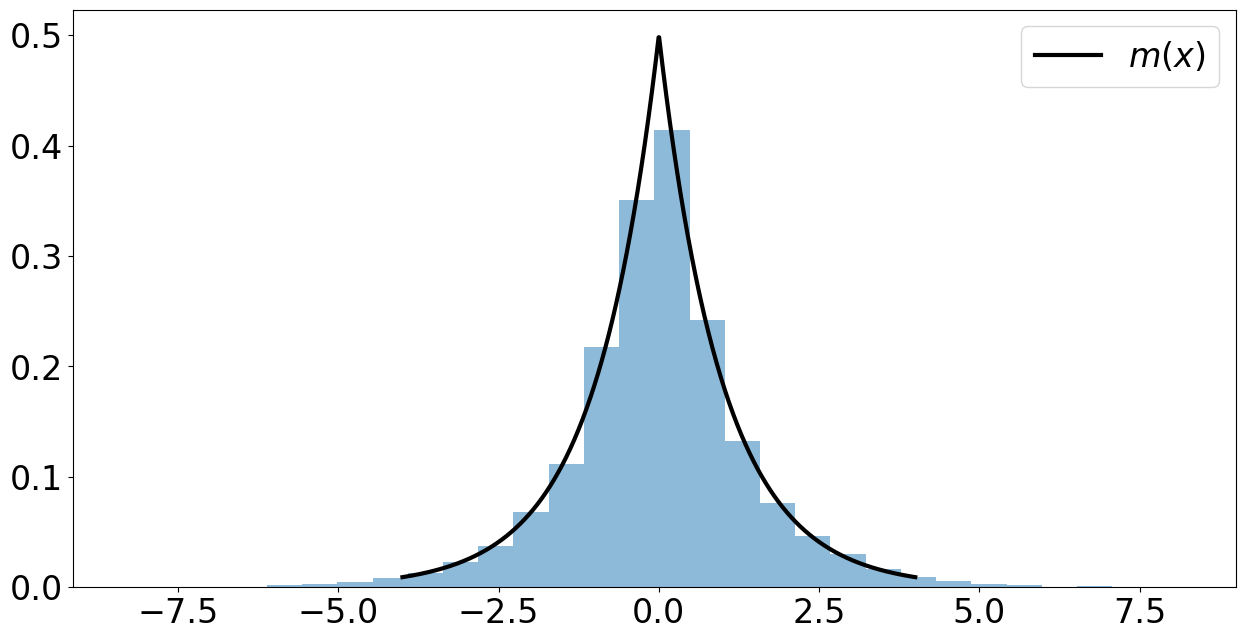

In [11]:
ls=np.linspace(-4,4,1000)
for m in range(M): plt.hist(ttrho[m,:],bins=30,alpha=0.5,density=True)
plt.plot(ls,np.exp(laplace_lm(ls[np.newaxis,:])),lw=3,c='black',label=r'$m(x)$')
plt.legend()

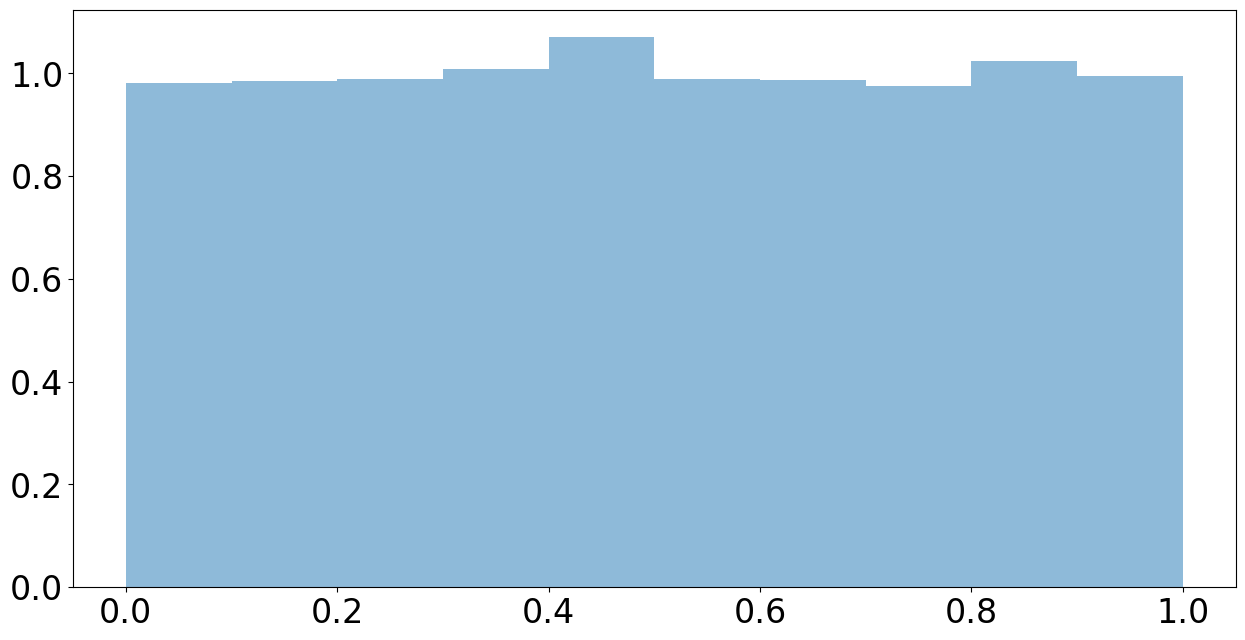

In [12]:
ls=np.linspace(-4,4,1000)
plt.hist(ttu,bins=10,alpha=0.5,density=True);

## Work in progress...

logJacobian: 0.06400535473631896
cum lJ: 0.06400535473631896
curr lq0: [-147.35794389 -147.0878609  -146.81832954 -146.5493536  -146.28093707
 -146.01308421 -145.74579952 -145.47908775 -145.21295395 -144.94740344
 -144.68244186 -144.41807517 -144.15430965 -143.89115197 -143.62860916
 -143.36668866 -143.10539833 -142.8447465  -142.58474197 -142.32539407
 -142.06671265 -141.80870819 -141.55139176 -141.29477514 -141.03887081
 -140.78369203 -140.52925293 -140.2755685  -140.02265475 -139.77052872
 -139.51920861 -139.26871387 -139.01906531 -138.77028523 -138.52239752
 -138.27542789 -138.02940397 -137.78435555 -137.54031476 -137.2973164
 -137.05539811 -136.81460082 -136.57496903 -136.33655128 -136.09940063
 -135.86357525 -135.62913909 -135.39616262 -135.16472383 -134.93490921
 -134.70681515 -134.48054941 -134.25623299 -134.03400245 -133.81401258
 -133.59643988 -133.38148676 -133.16938688 -132.96041191 -132.75488026
 -132.55316839 -132.35572593 -132.16309582 -131.97594216 -131.79508907
 -131.6

logJacobian: -0.14038707737648926
cum lJ: -6.224284998009372
curr lq0: [ -84.67131982  -53.31628573  -71.32088314  -84.32875368  -50.1021075
  -61.37250189  -53.38827241  -49.13091408  -98.35277574  -52.14049743
  -28.44713938  -70.56112959  -21.80050328  -48.06332342  -35.41980665
  -48.93232426  -53.71163532  -78.57273436  -36.51623243  -41.07443646
  -33.35261684  -65.87698021  -51.64599384  -51.0204737   -56.73277876
  -66.09537976  -74.9096185   -10.51204433  -48.6783711   -44.39914314
  -84.57420687  -49.31402019  -49.58392231  -30.98012143  -45.71294599
  -87.76490125  -60.16876587  -34.46693249  -61.49606824  -94.50637417
  -54.58616856  -70.2323173   -29.88536512  -61.06397239  -72.77093218
  -33.47155223  -45.98757243  -68.12988555  -41.10375836  -89.76002922
  -27.53226064  -38.22458478  -55.52913499  -35.68134629  -78.562272
  -56.47928912  -17.41933167  -70.56615833  -84.92476604  -46.06482802
  -13.80304558  -61.01469496  -65.78173338  -70.61554733  -48.4979215
  -54.1579

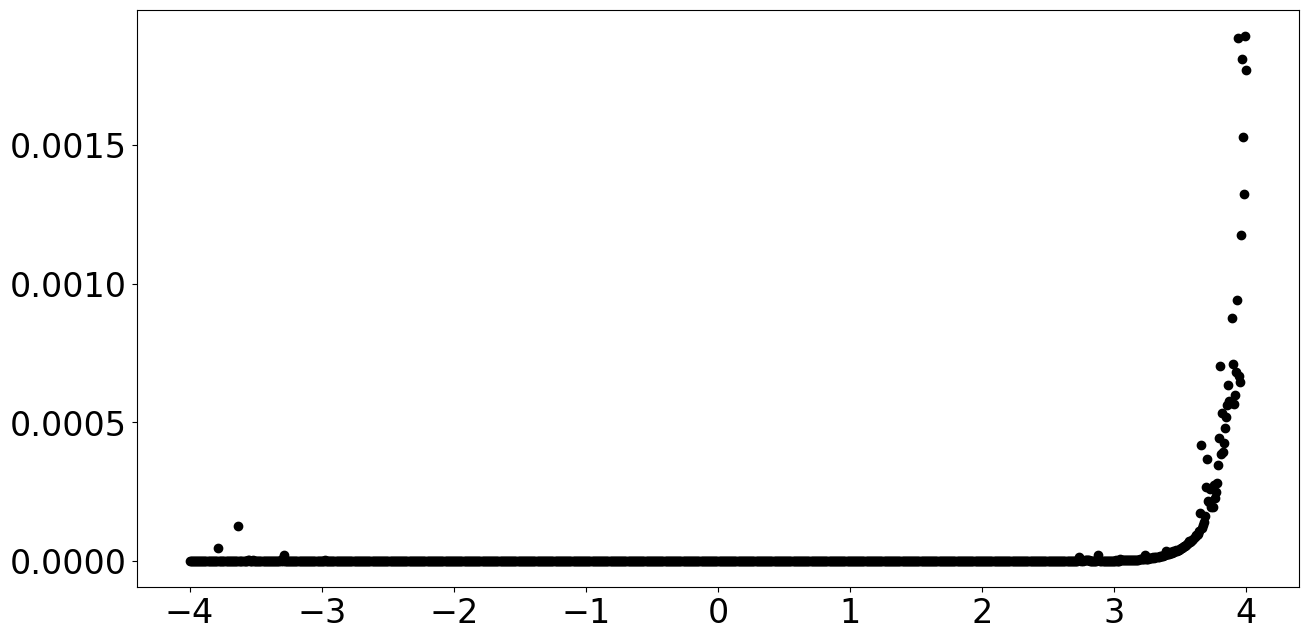

In [13]:
ls=np.linspace(-4,4,1000)
lapprox=lqN(ls[np.newaxis,:],np.zeros((1,ls.shape[0])),0.5*np.ones(ls.shape[0]),steps,L,eps,lq0,gradlp,momentum='laplace',xi=xi)
plt.plot(ls,np.exp(lapprox),'ok')

In [14]:
ls=np.linspace(-4,4,10000)
#tttx,tttrho,tttu,tljs=flow(ls[np.newaxis,:],np.random.laplace(size=(1,ls.shape[0])),np.random.rand(ls.shape[0]),steps,L,eps,gradlp,momentum='laplace',direction='bwd',xi=xi)
tttx,tttrho,tttu,tljs=flow(tx,trho,tu,steps,L,eps,gradlp,momentum='laplace',direction='bwd',xi=xi)
#tttx,tttrho,tttu,tljs=flow(np.random.randn(1,ls.shape[0]),trho[0,:].reshape(1,ls.shape[0]),tu,steps,L,eps,gradlp,momentum='laplace',direction='bwd',xi=xi)


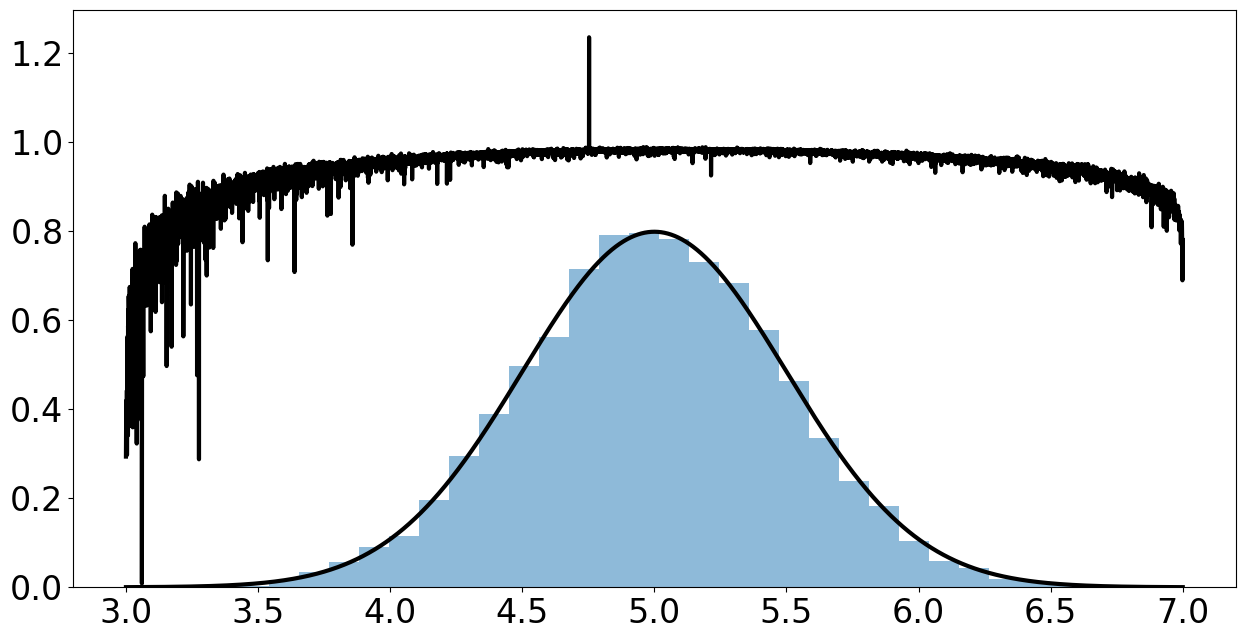

In [15]:
ls=np.linspace(mu0-4*sd0,mu0+4*sd0,10000)
plt.hist(tttx[0,:],bins=30,alpha=0.5,density=True);
mytttx=np.sort(tttx)
mytttljs=tljs[np.argsort(tttx[0,:])]
#plt.plot(ls,np.exp(lq0(tttx,tttrho,tttu)))
plt.plot(ls,np.exp(gauss_lp(ls[np.newaxis,:])),lw=3,c='black',label=r'$q_0(x)$')
#plt.plot(ls,np.exp(lq0(tttx,tttrho,tttu)),lw=3,c='black',label=r'$q_0(x)$')
plt.plot(ls,np.exp(gauss_lp(np.sort(tttx))/mytttljs),lw=3,c='black',label=r'$q_0(x)$')

logJacobian: 0.22092545919821482
cum lJ: 0.22092545919821482
curr lq0: [-150.99498454 -119.37910882  -92.43976672  -70.03948931  -51.39721437
  -50.15681141  -24.91056533  -23.74411509  -15.18893015   -3.83703521]

logJacobian: -5.43718273177186
cum lJ: -5.216257272573645
curr lq0: [-130.6828018  -105.38937089  -88.64813669  -59.21758945  -40.60288604
  -61.24074253  -25.97271583  -30.90310765  -19.20531676   -1.91810719]

logJacobian: -0.7381055253504774
cum lJ: -5.954362797924123
curr lq0: [-115.81969628  -90.48868173 -101.80873293  -70.20093291  -42.03670232
  -61.02481801  -23.3409186   -22.44793705  -26.41245706   -6.58538656]

logJacobian: -0.18711078845558005
cum lJ: -6.141473586379703
curr lq0: [-102.25758549 -104.2942005  -117.12521987  -79.17430144  -51.92530536
  -51.01446561  -23.2160905   -18.34938427  -32.169226     -1.8960327 ]

logJacobian: -2.650441502879639
cum lJ: -8.791915089259343
curr lq0: [ -86.98214399  -92.78641959 -116.59064366  -67.69155614  -62.99218109
  -4

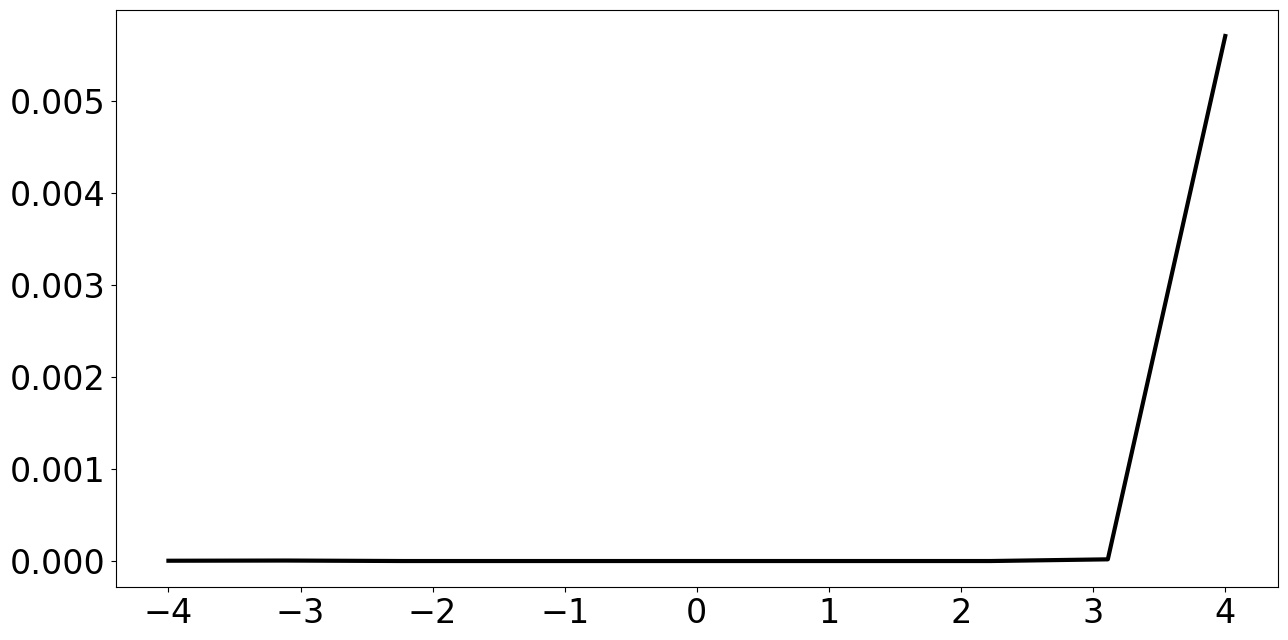

In [16]:
ls=np.linspace(-4,4,10)
myrho=np.sort(np.random.laplace(size=(1,ls.shape[0])))
myu=np.sort(np.random.rand(ls.shape[0]))
plt.plot(ls,np.exp(lqN(ls[np.newaxis,:],myrho,myu,steps,L,eps,lq0,gradlp,momentum='laplace',xi=xi)),lw=3,c='black')